# Lab 1 - Исследование набора данных

Выбранный датасет: U.S. Treasury Daily Yield Curve (ежедневная кривая доходности казначейских облигаций США)

Причины выбора:
- Полностью числовые данные, аккуратные даты, долгий исторический период (десятилетия)
- Много признаков (сроки 1M ... 30 Y), богато для корреляционного анализа
- Легко скачивается по прямым csv-ссылкам с оф. сайта
- Соответсвует интересам применения DS методов в финансовом прогнозировании и в целом в обработке временных рядов.

In [1]:
# импортируем библиотеки + настраиваем окружение
import os, io, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# настройка отображения
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

In [ ]:
# собираем 5 временных рядов и объединяем по дате (загрузил с FRED)
# читаем каждую серию из CSV, ищем имя колонок даты/значения, приводим к общей оси времени
# в частности, собирается список фреймов, берётся общая пересекающаяся индексация по датам
# затем конкатенация и приведение даты к колонке date

FRED_SERIES = {
    "3M":  "DGS3MO",
    "2Y":  "DGS2",
    "5Y":  "DGS5",
    "10Y": "DGS10",
    "30Y": "DGS30",
}
local_frames = []
# кандидаты для названия колонки даты (иногда они разные)
date_candidates = ["observation_date", "observationDate", "observationdate", "DATE", "Date", "date"]
for label, sid in FRED_SERIES.items():
    fname = f"{sid}.csv"
    if not os.path.exists(fname):
        continue
    try:
        tmp = pd.read_csv(fname)
    except Exception as e:
        print(f"Warning: не удалось прочитать {fname}: {e}")
        continue
    # гибко найдём колонку с датой
    date_col = next((c for c in date_candidates if c in tmp.columns), None)
    if date_col is None:
        print(f"Warning: в {fname} не найден столбец даты - проппуск")
        continue
    # найдём колонку со значением ставки
    if sid in tmp.columns:
        val_col = sid
    else:
        val_cols = [c for c in tmp.columns if c != date_col]
        if not val_cols:
            print(f"Warning: в {fname} нет столбца со значением - пропуск")
            continue
        val_col = val_cols[0]
    tmp[val_col] = pd.to_numeric(tmp[val_col].replace('.', np.nan), errors='coerce')
    tmp[date_col] = pd.to_datetime(tmp[date_col])
    tmp = tmp.rename(columns={val_col: label})
    tmp = tmp.set_index(date_col)[[label]]
    local_frames.append(tmp)

if not local_frames: # на всякий случай
    raise FileNotFoundError("Локальные DGS*.csv не найдены или не содержат колонку даты. Проверьте файлы в папке проекта.")

# объединим
# теперь объединим и сразу оставим только пересечение, чтоб не было затяжных bfill/ffill
all_idx = None
for frame in local_frames:
    if all_idx is None:
        all_idx = frame.index
    else:
        all_idx = all_idx.intersection(frame.index)

# оставим только даты, где есть значения во всех сериях
trimmed_frames = [f.loc[all_idx] for f in local_frames]

# объединяем по индексам
df_raw = pd.concat(trimmed_frames, axis=1, join='inner').sort_index().reset_index()

# переименуем колонку даты в 'Date' (на всякий случй, чтоб ошибок не было)
for cand in date_candidates:
    if cand in df_raw.columns:
        df_raw = df_raw.rename(columns={cand: 'Date'})
        break

# берем только то, что есть
expected = ["Date", "3M", "2Y", "5Y", "10Y", "30Y"]
present = [c for c in expected if c in df_raw.columns]
missing = [c for c in expected if c not in df_raw.columns]

df = df_raw[present].copy()

# покажем первые строки
df.head()

,Date,3M,2Y,5Y,10Y,30Y
0,1981-09-01,17.01,16.78,16.12,15.41,14.70
1,1981-09-02,16.65,16.78,16.09,15.40,14.70
2,1981-09-03,16.96,16.90,16.14,15.48,14.82
3,1981-09-04,16.64,16.89,16.17,15.51,14.84
4,1981-09-07,NaN,NaN,NaN,NaN,NaN


# Описание датасета
Предметная области: процентные ставки казначейства США по разным срокам (3 месяца, 2/5/10/30 лет)

Источнки: сайт Federal Reserve Economic Data

Ссылки:
3M (DGS3MO): https://fred.stlouisfed.org/series/DGS3MO

2Y (DGS2): https://fred.stlouisfed.org/series/DGS2

5Y (DGS5): https://fred.stlouisfed.org/series/DGS5

10Y (DGS10): https://fred.stlouisfed.org/series/DGS10

30Y (DGS30): https://fred.stlouisfed.org/series/DGS30

характер данных: реальные ежедневные значения в процентах годовых

Атрибуты: Date - дата наблюдения, далее колонки - доходность соответствующего срока в процентах годовых

Задачи анализа: временная динамика ставок, корреляции между сроками, форма кривой доходности

In [3]:
# доработанная версия обработки пропусков и дублей
print("Типы данных:")
print(df.dtypes)

print("\nПроверка дублей по дате:")
dup_count = df.duplicated(subset=["Date"]).sum()
print("Дубликатов:", dup_count)

print("\nКол-во пропусков по столбцам:")
print(df.isna().sum())

# удалим возможные дубли дат
df = df.drop_duplicates(subset=["Date"], keep="first").copy()

# заполняем ffill/bfill, т.к. ставки близки к непрерывным
# sort по дате
df_sorted = df.sort_values("Date")
# числовые колонки — все, кроме даты
num_cols = [c for c in df.columns if c != "Date"]
# сначала вперёд, затем назад (ffill затем bfill) чтобы заполнить пропуски на краях
df_sorted[num_cols] = df_sorted[num_cols].ffill().bfill()

print("остатки пропусков после заполнения")
print(df_sorted.isna().sum())
# заменяем основной df на обработанный
df = df_sorted.copy()
df.head()


Типы данных:
Date    datetime64[ns]
3M             float64
2Y             float64
5Y             float64
10Y            float64
30Y            float64
dtype: object

Проверка дублей по дате:
Дубликатов: 0

Кол-во пропусков по столбцам:
Date      0
3M      481
2Y      480
5Y      480
10Y     480
30Y     480
dtype: int64
остатки пропусков после заполнения
Date    0
3M      0
2Y      0
5Y      0
10Y     0
30Y     0
dtype: int64


,Date,3M,2Y,5Y,10Y,30Y
0,1981-09-01,17.01,16.78,16.12,15.41,14.70
1,1981-09-02,16.65,16.78,16.09,15.40,14.70
2,1981-09-03,16.96,16.90,16.14,15.48,14.82
3,1981-09-04,16.64,16.89,16.17,15.51,14.84
4,1981-09-07,16.64,16.89,16.17,15.51,14.84


In [4]:
num_cols = [c for c in df.columns if c != "Date"]

# описательная статистика по числовым колонкам
desc = df[num_cols].describe().T
desc = desc[["mean", "std", "min", "25%", "50%", "75%", "max"]]
display(desc)

# найдем отдельно сводку
stats = df[num_cols].agg(["mean", "std", "min", "max"])
display(stats)

,mean,std,min,25%,50%,75%,max
3M,3.831902,3.147995,0.00,0.91,3.990,5.62,17.01
2Y,4.437589,3.379064,0.09,1.40,4.240,6.32,16.95
5Y,4.940538,3.255881,0.19,2.22,4.450,6.75,16.27
10Y,5.386599,3.080655,0.52,2.92,4.655,7.21,15.84
30Y,5.809797,2.835108,0.99,3.65,5.150,7.52,15.21


,3M,2Y,5Y,10Y,30Y
mean,3.831902,4.437589,4.940538,5.386599,5.809797
std,3.147995,3.379064,3.255881,3.080655,2.835108
min,0.000000,0.090000,0.190000,0.520000,0.990000
max,17.010000,16.950000,16.270000,15.840000,15.210000


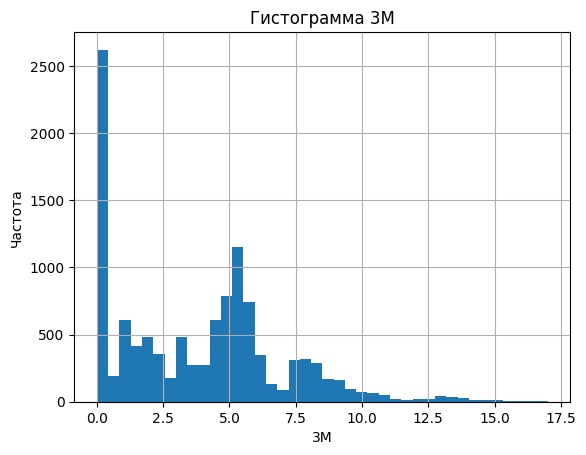

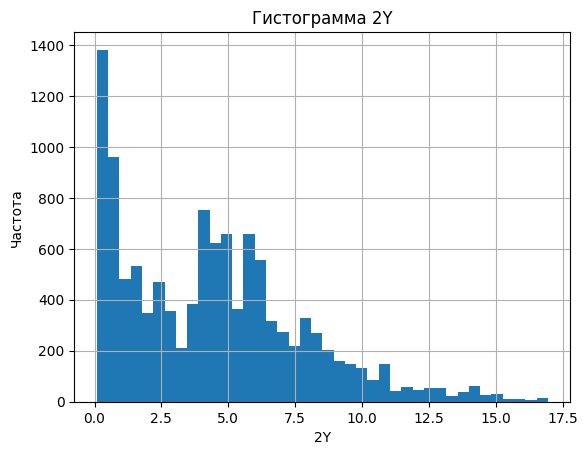

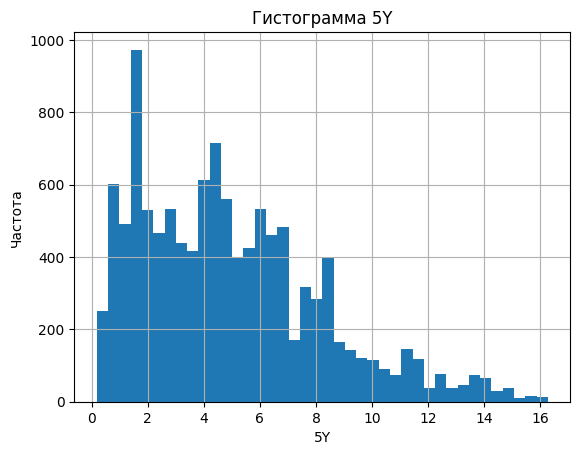

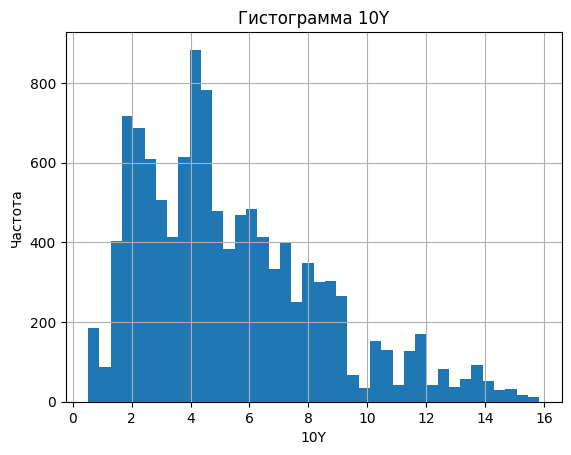

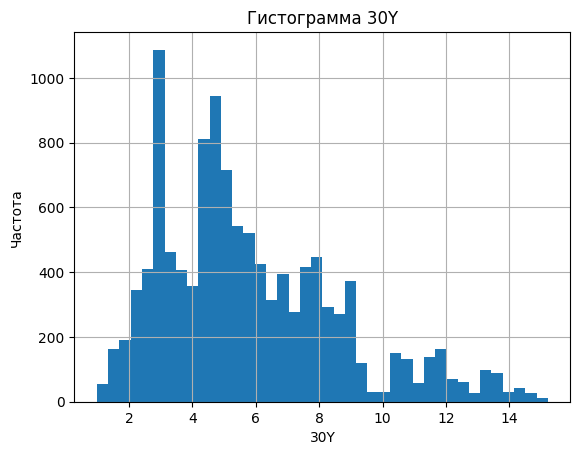

In [5]:
#гистограммы распределений (одна фигура на каждый принзак)
for col in num_cols:
    plt.figure()
    df[col].hist(bins=40)
    plt.title(f"Гистограмма {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.show()


Замечание: трехмесячный таймфрейм имеет характерный штырь в районе 0 - это не искажение. В США действительно в 2009-2015 годах была крайне низкая процентная ставка, близкая к нулю.

In [ ]:
# поиск выбросов по размаху для всех числовых признаков и их дневных разностей
# флаги выбросов для уровней + для суточных изменений
num_cols = [c for c in df.columns if c not in ("Date", "d10y")]
for col in num_cols:
    df[f"is_outlier_{col}"] = 0
    df[f"is_outlier_diff_{col}"] = 0

outlier_summary = []
for col in num_cols:
    # уровни
    series = df[col].dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    mask = (df[col] < lo) | (df[col] > hi)
    df.loc[mask, f"is_outlier_{col}"] = 1
    n_out = int(mask.sum())

    # суточные разности
    diff = df[col].diff()
    q1d = diff.quantile(0.25)
    q3d = diff.quantile(0.75)
    iqrd = q3d - q1d
    lod = q1d - 3 * iqrd
    hid = q3d + 3 * iqrd
    maskd = (diff < lod) | (diff > hid)
    df.loc[maskd, f"is_outlier_diff_{col}"] = 1
    n_out_d = int(maskd.sum())

    outlier_summary.append({
        "feature": col,
        "n_level_outliers": n_out,
        "n_diff_outliers": n_out_d,
        "level_lo": float(lo),
        "level_hi": float(hi),
        "diff_lo": float(lod),
        "diff_hi": float(hid),
    })

out_df = pd.DataFrame(outlier_summary).set_index("feature")
print("Сводка выбросов (уровни / суточные разности):")
display(out_df)

print("Всего помечено выбросов по уровням (sum по флагам):")
display(df[[f"is_outlier_{c}" for c in num_cols]].sum())
print("Всего помечено выбросов по суточным разностям (sum по флагам):")
display(df[[f"is_outlier_diff_{c}" for c in num_cols]].sum())

# оригиналоьный специально рассчитанный признак d10y оставим для совместимости
df["d10y"] = df["10Y"].diff()

# показ несколько строк с пометками
df[["Date"] + [c for c in df.columns if c.startswith("is_outlier")]].head()

Сводка выбросов (уровни / суточные разности):


,n_level_outliers,n_diff_outliers,level_lo,level_hi,diff_lo,diff_hi
feature,,,,,,
3M,159,1246,-6.155,12.685,-0.07,0.07
2Y,187,187,-5.980,13.700,-0.21,0.21
5Y,238,153,-4.575,13.545,-0.21,0.21
10Y,217,75,-3.515,13.645,-0.25,0.24
30Y,225,84,-2.155,13.325,-0.21,0.21


Всего помечено выбросов по уровням (sum по флагам):


is_outlier_3M     159
is_outlier_2Y     187
is_outlier_5Y     238
is_outlier_10Y    217
is_outlier_30Y    225
dtype: int64

Всего помечено выбросов по суточным разностям (sum по флагам):


is_outlier_diff_3M     1246
is_outlier_diff_2Y      187
is_outlier_diff_5Y      153
is_outlier_diff_10Y      75
is_outlier_diff_30Y      84
dtype: int64

,Date,is_outlier_3M,is_outlier_diff_3M,is_outlier_2Y,is_outlier_diff_2Y,is_outlier_5Y,is_outlier_diff_5Y,is_outlier_10Y,is_outlier_diff_10Y,is_outlier_30Y,is_outlier_diff_30Y
0,1981-09-01,1,0,1,0,1,0,1,0,1,0
1,1981-09-02,1,1,1,0,1,0,1,0,1,0
2,1981-09-03,1,1,1,0,1,0,1,0,1,0
3,1981-09-04,1,1,1,0,1,0,1,0,1,0
4,1981-09-07,1,0,1,0,1,0,1,0,1,0


Корреляционная матрица (pearson)


,3M,2Y,5Y,10Y,30Y
3M,1.000000,0.981822,0.951103,0.919412,0.885541
2Y,0.981822,1.000000,0.989114,0.967924,0.941109
5Y,0.951103,0.989114,1.000000,0.993395,0.977788
10Y,0.919412,0.967924,0.993395,1.000000,0.994872
30Y,0.885541,0.941109,0.977788,0.994872,1.000000


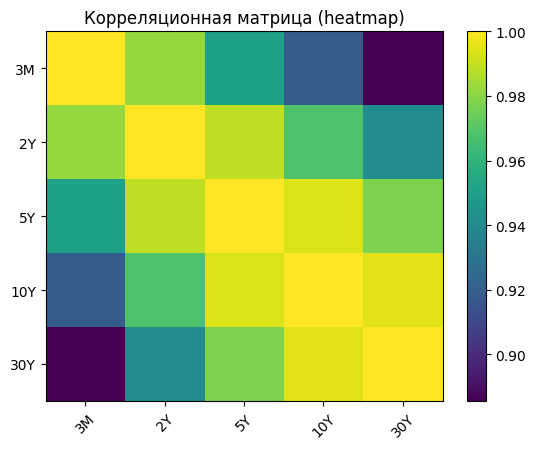

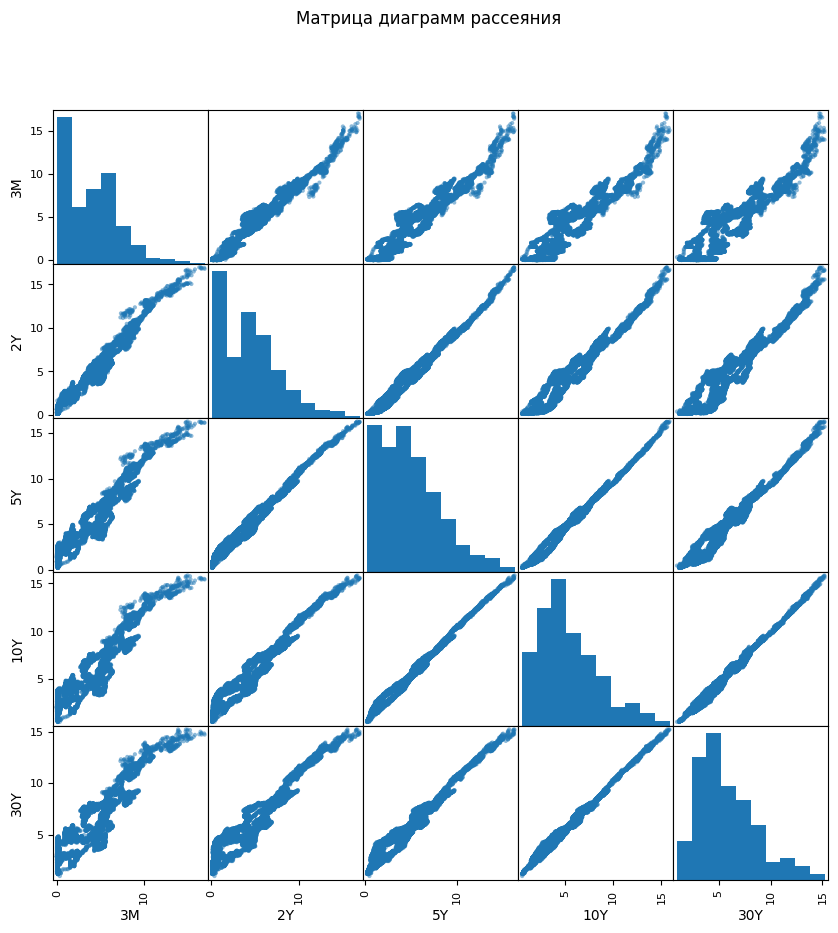

In [7]:
# Корреляции и матрица диаграмм рассеяния
corr = df[num_cols].corr(method="pearson")
print("Корреляционная матрица (pearson)")
display(corr)

plt.figure()
plt.imshow(corr.values, aspect="auto")
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=45)
plt.yticks(ticks=range(len(num_cols)), labels=num_cols)
plt.colorbar()
plt.title("Корреляционная матрица (heatmap)")
plt.show()

#матрица диаграмм рассеяния
scatter_matrix(df[num_cols], figsize=(10,10), diagonal="hist")
plt.suptitle("Матрица диаграмм рассеяния")
plt.show()

# Выводы
- ставки по соседним срокам ожидаемо сильно каррелируют, матрица показывает высокие положительные корреляции
- по дневным изменениям выбросы редки, их можно исключить при обучении моделй
- заполнение пропусков ffill/bfill допустимо для ставок (т.к. это инструмент без каких-либо скачкообразных изменений), НО (большое НО): их не стоит использовать бездумно через большие интервалы, иначе задним числом первое доступное значение может протянуться на годы вперед, а на гистограммах будут характериные "штыки", что искажает картину
- распределения уровней ставок многомодальные, т.к. имеют разные экономические режимы
